In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import hstack, csr_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [79]:
import pandas as pd
data_original = pd.read_csv("data_final.csv")

data = data_original

query_counts = data["search_query"].value_counts()
print(query_counts)

search_query
2hollis type beat     252
nate sib type beat    193
hyperpop type beat    189
Name: count, dtype: int64


In [81]:
# Select a specific search query
search_terms = ["2hollis type beat", "nate sib type beat", "hyperpop type beat"]

df = data[data["search_query"].apply(lambda x: any(term in str(x) for term in search_terms))]


In [ ]:

# Drop videos with less than 100 views, starting channels mostly noise and not representative for features
df = df[df['views'] > 100].copy()

df['tags'] = df['tags'].fillna('').str.lower()
#df['tags'] = df['tags'].str.split('|')

# Split train/test
X = df.drop(columns=['views'])
y = df['views']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ln transform views
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Title keywords unigrams and bigrams
tfidf_title = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
X_train_title = tfidf_title.fit_transform(X_train_raw['title'].fillna(''))
X_test_title = tfidf_title.transform(X_test_raw['title'].fillna(''))

X_train_raw['tags_str'] = X_train_raw['tags'].apply(lambda tags: ' '.join(tags) if isinstance(tags, list) else '')
X_test_raw['tags_str'] = X_test_raw['tags'].apply(lambda tags: ' '.join(tags) if isinstance(tags, list) else '')

# Tags separated by | so each tag is what is used in the youtube studio
tfidf_tags = TfidfVectorizer(tokenizer=lambda x: x.split('|'), lowercase=False, max_features=100, token_pattern=None)

X_train_tags = tfidf_tags.fit_transform(X_train_raw['tags'].fillna(''))
X_test_tags = tfidf_tags.transform(X_test_raw['tags'].fillna(''))



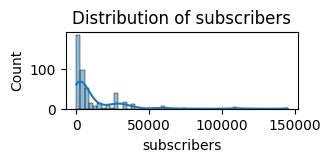

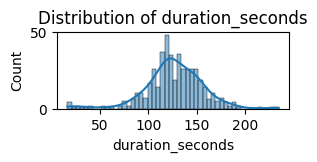

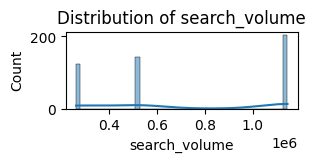

In [84]:
# Numeric features
numerical_cols = ['subscribers', 'duration_seconds', 'search_volume']

X_train_num = X_train_raw[numerical_cols].copy()
X_test_num = X_test_raw[numerical_cols].copy()

import seaborn as sns
import matplotlib.pyplot as plt

for col in numerical_cols:
    plt.figure(figsize=(3, 1))
    sns.histplot(X_train_raw[col].dropna(), bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# Apply ln transform only to 'subscribers' because the distribution is skewed
X_train_num['subscribers'] = np.log1p(X_train_num['subscribers'])
X_test_num['subscribers'] = np.log1p(X_test_num['subscribers'])

# Scale all numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Combine multiple feature matrices horizontally into one big sparse matrix for training data
X_train_combined = hstack([
    X_train_title,               # Sparse matrix of TF-IDF features from the 'title' column (shape: n_samples x n_title_features)
    X_train_tags,                # Sparse matrix of TF-IDF features from the 'tags' column (shape: n_samples x n_tag_features)
    csr_matrix(X_train_num_scaled)  # Numeric features (scaled), converted to sparse format (shape: n_samples x n_numeric_features)
])

X_test_combined = hstack([
    X_test_title,
    X_test_tags,
    csr_matrix(X_test_num_scaled)
])


In [85]:
print("Title features:", X_train_title.shape[1])
print("Tags features:", X_train_tags.shape[1])
print("Numeric features:", X_train_num_scaled.shape[1])
print("Combined features:", X_train_combined.shape[1])

import pandas as pd

# Get feature names for each block
title_feats = tfidf_title.get_feature_names_out()
tags_feats = tfidf_tags.get_feature_names_out()
num_feats = numerical_cols

# Combine all feature names in order
all_feats = list(title_feats) + list(tags_feats) + list(num_feats)

# Convert a small sample to dense and then DataFrame
df_sample = pd.DataFrame(X_train_combined[:5, :].toarray(), columns=all_feats)



Title features: 100
Tags features: 100
Numeric features: 3
Combined features: 203


## Random Forest Regression

In [86]:
from sklearn.model_selection import RandomizedSearchCV

# Define the model
rf_model = RandomForestRegressor(random_state=123)

# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.5, 0.75],  # use valid options (float fraction or 'sqrt')
    'bootstrap': [True],  # avoid False if causing problems
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,            # number of parameter settings sampled
    cv=3,                 # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1             # use all CPU cores
)

# Fit RandomizedSearchCV to training data
random_search.fit(X_train_combined, y_train_log)

# Best hyperparameters found
print("Best parameters:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 20, 'bootstrap': True}


In [87]:
# Evaluate on test set with best estimator
best_rf = random_search.best_estimator_
y_pred_log = best_rf.predict(X_test_combined)

rmse_log = mean_squared_error(y_test_log, y_pred_log)
r2 = r2_score(y_test_log, y_pred_log)

print(f"Optimized Test RMSE (log scale): {rmse_log:.4f}")
print(f"Optimized Test R² (log scale): {r2:.4f}")


Optimized Test RMSE (log scale): 2.0031
Optimized Test R² (log scale): 0.4631


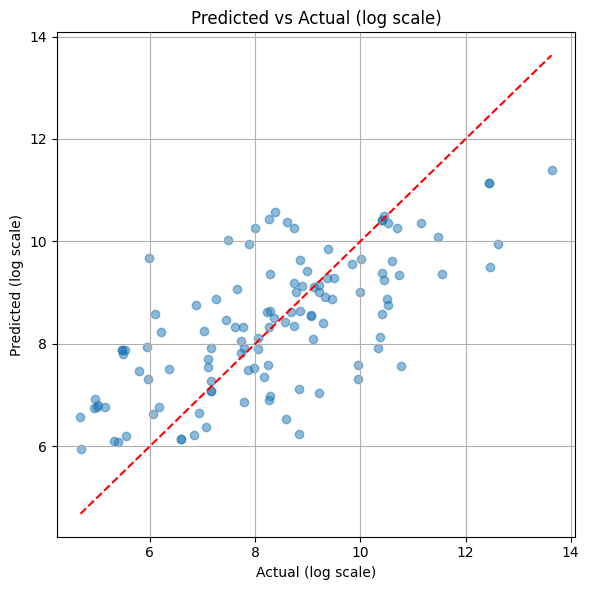

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_log, y_pred_log, alpha=0.5)
plt.plot([min(y_test_log), max(y_test_log)], [min(y_test_log), max(y_test_log)], color='red', linestyle='--')  # diagonal line y=x
plt.xlabel('Actual (log scale)')
plt.ylabel('Predicted (log scale)')
plt.title('Predicted vs Actual (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()



Feature importance by original field:
                  importance
title               0.341239
subscribers         0.322797
tags                0.268797
duration_seconds    0.039050
search_volume       0.028117


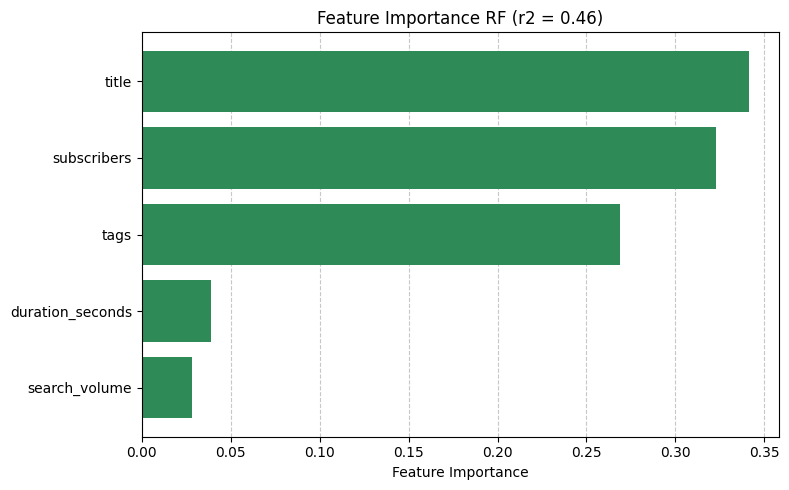

In [89]:
# Get feature importance for each original feature
importances = best_rf.feature_importances_

len_title = X_train_title.shape[1]
len_tags = X_train_tags.shape[1]
len_num = len(numerical_cols)

# Get the slices containing title and tags
importance_by_field = {
    'title': importances[0:len_title].sum(),
    'tags': importances[len_title:len_title + len_tags].sum(),
}

# Get the numerical columns (each separately)
for i, col in enumerate(numerical_cols):
    importance_by_field[col] = importances[(len_title + len_tags) + i]

importance_df = pd.DataFrame.from_dict(importance_by_field, orient='index', columns=['importance'])
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("\nFeature importance by original field:")
print(importance_df)

importance_df_sorted = importance_df.sort_values(by='importance', ascending=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.grid(axis='x', linestyle='--', alpha=0.7, zorder=0)
plt.barh(importance_df_sorted.index, importance_df_sorted['importance'], color='seagreen', zorder=2)
plt.xlabel('Feature Importance')
plt.title(f'Feature Importance RF (r2 = {r2:.2f})')
plt.tight_layout()
plt.show()


In [90]:
# Get feature importances per feature
title_importances = importances[0:len_title]
tags_importances = importances[len_title:len_title + len_tags]

# Get feature names from the vectorizers
title_features = tfidf_title.get_feature_names_out()
tags_features = tfidf_tags.get_feature_names_out()

# Create DataFrames with individual feature importances (1 or 2 words)
df_title_imp = pd.DataFrame({'keyword': title_features, 'importance': title_importances})
df_tags_imp = pd.DataFrame({'tag': tags_features, 'importance': tags_importances})

df_title_imp = df_title_imp.sort_values(by='importance', ascending=False)
df_tags_imp = df_tags_imp.sort_values(by='importance', ascending=False)

# Display top 20 important features for each
print("Top 10 Title Keywords by Importance:")
print(df_title_imp.head(10))

print("\nTop 10 Tag keywords by Importance:")
print(df_tags_imp.head(10))


Top 10 Title Keywords by Importance:
          keyword  importance
69           prod    0.039068
2         2hollis    0.037631
81            sib    0.037209
45       hyperpop    0.027444
58           nate    0.025866
59       nate sib    0.025669
30           free    0.021220
10           beat    0.014932
96      type beat    0.013949
48  hyperpop type    0.013749

Top 10 Tag keywords by Importance:
                        tag  importance
74       nate sib type beat    0.025195
1        100 gecs type beat    0.022533
58       hyperpop type beat    0.020393
62  hyperpop type beat free    0.019328
7         2hollis type beat    0.014603
78  playboi carti type beat    0.013961
37  free hyperpop type beat    0.013304
70        midwxst type beat    0.010789
17       brakence type beat    0.008348
16         bladee type beat    0.007393


## LASSO on numerical only

In [ ]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_num_scaled, y_train_log)

y_pred_log = lasso.predict(X_test_num_scaled)
rmse = mean_squared_error(y_test_log, y_pred_log)
r2 = r2_score(y_test_log, y_pred_log)
print(f"Test RMSE (log scale): {rmse:.4f}")
print(f"Test R² (log scale): {r2:.4f}")

coef = lasso.coef_
df_coef = pd.DataFrame({'feature': numerical_cols, 'coef': coef})
df_coef = df_coef.reindex(df_coef['coef'].abs().sort_values(ascending=False).index)

print("\nNumeric Feature Coefficients (with direction):")
print(df_coef)


Test RMSE (log scale): 2.3492
Test R² (log scale): 0.3703

Numeric Feature Coefficients (with direction):
            feature      coef
0       subscribers  0.942768
2     search_volume  0.161774
1  duration_seconds  0.069753


In [ ]:
# LASSO does not support csr matrix
X_train_dense = X_train_combined.toarray()
X_test_dense = X_test_combined.toarray()


In [105]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Define parameter grid for alpha and max_iter (you can add more params if needed)
param_grid = {
    'alpha': np.logspace(-4, 1, 50),  # Search alphas from 0.0001 to 10
    'max_iter': [10000, 20000]
}

# Initialize base model
lasso = Lasso(random_state=42)

# Setup GridSearchCV with 5-fold CV, using neg MSE as scoring
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_dense, y_train_log)

print(f"Best params: {grid_search.best_params_}")

# Use best estimator for prediction
best_lasso = grid_search.best_estimator_
y_pred_log_lasso = best_lasso.predict(X_test_dense)

# Evaluate test performance
rmse = mean_squared_error(y_test_log, y_pred_log)
r2 = r2_score(y_test_log, y_pred_log)
print(f"Test RMSE (log scale): {rmse:.4f}")
print(f"Test R² (log scale): {r2:.4f}")


Best params: {'alpha': np.float64(0.006866488450042998), 'max_iter': 10000}
Test RMSE (log scale): 1.9270
Test R² (log scale): 0.4835


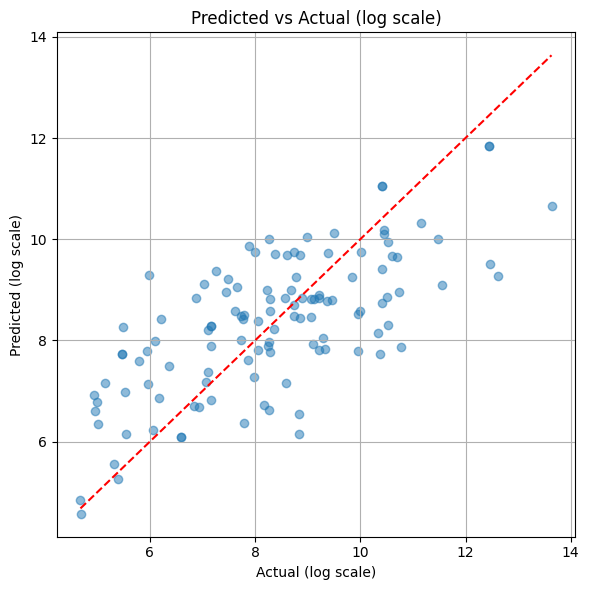

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_log, y_pred_log_lasso, alpha=0.5)
plt.plot([min(y_test_log), max(y_test_log)], [min(y_test_log), max(y_test_log)], color='red', linestyle='--')  # diagonal line y=x
plt.xlabel('Actual (log scale)')
plt.ylabel('Predicted (log scale)')
plt.title('Predicted vs Actual (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [108]:
# Extract coefficients
coef = best_lasso.coef_

# Get feature names from each part
title_features = tfidf_title.get_feature_names_out()
tags_features = tfidf_tags.get_feature_names_out()
num_features = numerical_cols

# Combine all feature names in the same order as the combined matrix
all_features = np.concatenate([title_features, tags_features, num_features])

# Create source labels for each feature
n_title = len(title_features)
n_tags = len(tags_features)
n_num = len(num_features)

source_labels = (
    ['title'] * n_title +
    ['tags'] * n_tags +
    ['numeric'] * n_num
)

# Create DataFrame with features, coefficients, and source
df_coef = pd.DataFrame({
    'feature': all_features,
    'coef': coef,
    'source': source_labels
})

# Sort by absolute coefficient magnitude descending
df_coef = df_coef.reindex(df_coef['coef'].abs().sort_values(ascending=False).index)

print("\nTop 20 Features by Absolute Coefficient:")
print(df_coef.head(20))


Top 20 Features by Absolute Coefficient:
                            feature      coef   source
88                         star boy  2.414126    title
174              nate sib type beat -2.047429     tags
2                           2hollis -1.994050    title
39                       glitchcore  1.608057    title
101              100 gecs type beat  1.294351     tags
47                   hyperpop style -1.140599    title
178         playboi carti type beat  0.975910     tags
35                    free hyperpop  0.905040    title
3                     2hollis gunnr  0.866377    title
85                         sib type -0.846076    title
69                             prod  0.814029    title
58                             nate -0.802178    title
200                     subscribers  0.786211  numeric
128           electro pop type beat -0.726330     tags
110  2hollis x hard dance type beat  0.722932     tags
115                            beat  0.601517     tags
122                 dan